In [102]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta
from kmeans_gmm_eval_fns import gmm_model_get_prediction_ae, gmm_model_get_prediction_pca



In [103]:
x_train_scaled = pd.read_csv('../data/260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                            ...             
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.529274   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.485551   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.682864   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.760504   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.601023   
...                ...       ...       ...       ...  ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.403338   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.563382   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.278042   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.455270   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.000000   

              LOC646430  LOC441956     ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                   
55_control          0.0        0.0  0.364776  0.465986  0.922559  0.854193   
168_CD_plain        0.0        0.0  0.522378  0.578564  0.522145  0.692076   
72_control          0.0        0.0  0.042221  0.025102  0.789751  0.878183   
120_control         0.0        0.0  0.517359  0.672548  0.565864  0.505961   
258_CD_plain        0.0        0.0  0.490289  0.858259  0.686037  0.392018   
...                 ...        ...       ...       ...       ...       ...   
15_CD_plain         0.0        0.0  0.568061  0.445374  0.442044  0.695490   
182_CD_plain        0.0        0.0  0.457702  0.485198  0.507829  0.801229   
164_CD_plain        0.0        0.0  0.474069  0.769644  0.659954  0.314433   
53_CD_plain         0.0        0.0  0.506542  0.676451  0.677115  0.459944   
97_CD_plain         0.0        0.0  0.354709  0.345159  0.251259  0.607139   

              LOC389458     PTPN7  RPS12P31  
Patient_ID                                   
55_control     0.224260  0.883418       0.0  
168_CD_plain   0.021080  0.517763       0.0  
72_control     0.048352  0.429987       0.0  
120_control    0.021080  0.490510       0.0  
258_CD_plain   0.021080  0.633386       0.0  
...                 ...       ...       ...  
15_CD_plain    0.021080  0.324311       0.0  
182_CD_plain   0.021080  0.574480       0.0  
164_CD_plain   0.167705  0.847694       0.0  
53_CD_plain    0.021080  0.659798       0.0  
97_CD_plain    0.132905  0.733472       0.0  

[182 rows x 220 columns]

In [104]:
x_test_scaled = pd.read_csv('../data/260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.799811   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.843182   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.442893   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.511169   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.498080   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.273104   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.540150   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.561707   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.260826   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.598137   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
253_CD_plain             0.0        0.0  0.315927  0.580699  0.652889   
105_CD_plain             0.0        0.0  0.233173  0.420656  0.461041   
2_CD_plain               0.0        0.0  1.044816  0.972319  0.998363   
184_CD_plain             0.0        0.0  0.457879  0.591956  0.665982   
312_CD_plain             0.0        0.0  0.583310  0.741909  0.691929   
...                      ...        ...       ...       ...       ...   
107_CD_plain             0.0        0.0  0.511460  0.571813  0.718136   
279_CD_plain             0.0        0.0  0.967121  0.690670  0.586834   
179_CD_plain             0.0        0.0  0.532892  0.827410  0.584298   
70_CD_deep_ulcer         0.0        0.0  0.353435  0.470313  0.693233   
256_CD_deep_ulcer        0.0        0.0  0.550635  0.712620  0.543815   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
253_CD_plain       0.283662   0.021080  0.271046       0.0  
105_CD_plain       0.783732   0.050226  0.510625       0.0  
2_CD_plain         0.013298   0.021080  0.674434       0.0  
184_CD_plain       0.460966   0.066515  0.616797       0.0  
312_CD_plain       0.483119   0.021080  0.646119       0.0  
...                     ...        ...       ...       ...  
107_CD_plain       0.624635   0.021080  0.939056       0.0  
279_CD_plain       0.731743   0.021080  0.312015       0.0  
179_CD_plain       0.217127   0.195470  0.876301       0.0  
70_CD_deep_ulcer   0.466546   0.045757  0.799992       0.0  
256_CD_deep_ulcer  0.510634   0.021080  0.597887       0.0  

[78 rows x 220 columns]

In [105]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [106]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [107]:
compound_model = keras.models.load_model('../data/models/cd_clf')

In [108]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 440)               97240     
                                                                 
 batch_normalization (BatchN  (None, 440)              1760      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 440)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               97020     
                                                                 
 batch_normalization_1 (Batc  (None, 220)              880       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 220)               0

## SHAP evaluation

In [109]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [110]:
import objects

In [111]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[18])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [112]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [113]:
# shap_values

## Independent - 41

In [114]:
idx = 41

In [115]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [116]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [117]:

with open("../data/models/shap/ind_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [118]:
# shap_values[0][0].shape

In [119]:
shap_values = shap_values[0]

In [120]:
# shap_values[0] *= 100000

In [121]:
shap_values

[array([[ 0.00000000e+00, -6.36190743e+00,  1.35416033e+01,
         -2.93478057e+01,  0.00000000e+00,  0.00000000e+00,
          1.42023317e+01, -1.07638383e+01, -1.03859085e+00,
          2.00967954e-01,  1.11218604e-01,  0.00000000e+00,
          0.00000000e+00,  1.71536953e+01, -1.15802395e+01,
          0.00000000e+00,  8.30755742e+00,  1.68910226e+01,
         -3.31769370e+00,  1.42725275e+01,  0.00000000e+00,
         -2.80785752e+01,  1.46029733e+01,  1.42640842e+01,
         -7.42937652e+00,  1.42554097e+01,  1.42376984e+01,
          7.35193348e+00,  2.48971641e+01,  0.00000000e+00,
          1.29616838e-01,  1.38312763e+01,  1.11829610e+01,
          1.17764924e+01,  0.00000000e+00,  0.00000000e+00,
         -2.72154495e+00, -9.93244532e+00,  0.00000000e+00,
         -1.28245910e+01,  6.72133378e+00, -3.98426511e-01,
         -1.42373887e+01,  0.00000000e+00,  0.00000000e+00,
          5.29287412e+00,  1.41713597e+01, -2.34554237e+01,
          0.00000000e+00, -5.67019135e+0

In [122]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [123]:

patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
260_CD_deep_ulcer  0.588189  0.625309  0.750597  0.746795  0.678619  0.578012   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     MICA  \
Patient_ID                                                 ...            
260_CD_deep_ulcer  0.191236  0.321755  0.595506  0.569387  ...  0.69275   

                   LOC646430  LOC441956     ITGAV    SMCHD1      ASPN  \
Patient_ID                                                              
260_CD_deep_ulcer        0.0        0.0  0.486189  0.553708  0.569272   

                     TMEM97  LOC389458     PTPN7  RPS12P31  
Patient_ID                                                  
260_CD_deep_ulcer  0.530402    0.28222  0.529513       0.0  

[1 rows x 220 columns]

In [124]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 69ms/step
Prediction probabilities for patient: [0.07070122 0.6113825  0.3179162 ]
Predicted class:


#### Control

In [125]:
import shap

In [126]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [127]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [128]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [129]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

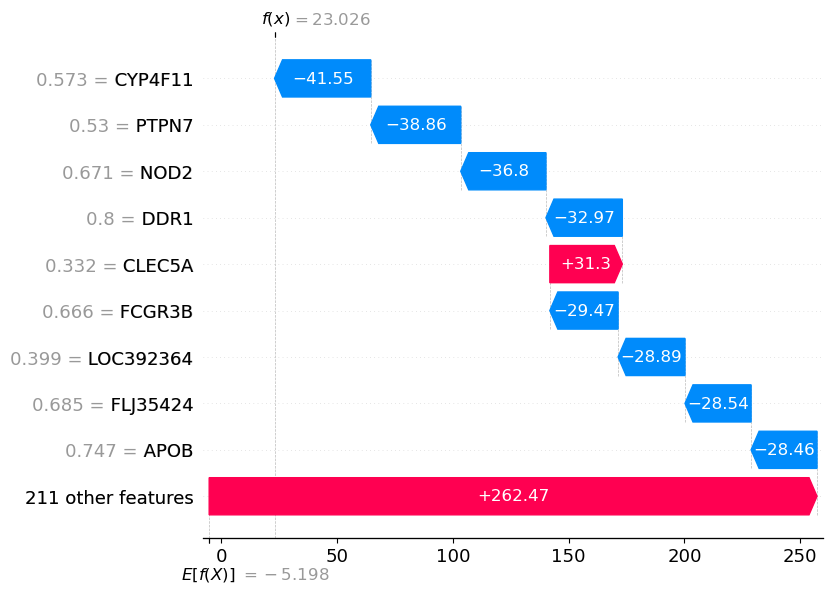

In [130]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 41

In [131]:
idx = 41

In [132]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [133]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [134]:

with open("../data/models/shap/fd_41", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

FileNotFoundError: [Errno 2] No such file or directory: '../data/models/shap/fd_41'

In [ ]:
# shap_values[0][0].shape

In [ ]:
shap_values = shap_values[0]

In [ ]:
# shap_values[0] *= 100000

In [ ]:
shap_values

In [ ]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [ ]:
idx = 41
patient = x_test_scaled.iloc[[idx],:]
patient

In [ ]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

#### Control

In [ ]:
import shap

In [ ]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [ ]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [ ]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [ ]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 41
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

In [ ]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Dependent - 18

In [135]:
idx = 18

In [136]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=True, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [137]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [138]:

with open("../data/models/shap/fd_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [139]:
# shap_values[0][0].shape

In [140]:
shap_values = shap_values[0]

In [141]:
# shap_values[0] *= 100000

In [142]:
shap_values

[array([[ 0.00000000e+00, -5.22505352e+00,  1.18036530e+01,
         -2.77484205e+01,  0.00000000e+00,  0.00000000e+00,
          1.38298246e+01, -1.12791626e+01, -1.42524343e+00,
          3.52337024e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.72756387e+01, -1.21339475e+01,
          0.00000000e+00,  7.40939941e+00,  1.64535283e+01,
         -2.72106756e+00,  1.38551969e+01,  0.00000000e+00,
         -2.56584541e+01,  1.44613628e+01,  1.38940235e+01,
         -6.71697911e+00,  1.42566175e+01,  1.35863111e+01,
          6.00849206e+00,  2.31276095e+01, -8.30962662e-03,
          1.62599895e+00,  1.43888768e+01,  1.06825059e+01,
          1.05300365e+01,  3.04011105e-01,  0.00000000e+00,
         -2.47107405e+00, -1.10997289e+01,  0.00000000e+00,
         -1.35061666e+01,  7.90567599e+00,  7.87162188e-01,
         -1.39983395e+01,  0.00000000e+00,  0.00000000e+00,
          3.58673490e+00,  1.48218264e+01, -2.10953642e+01,
          0.00000000e+00, -4.07799716e+0

In [143]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

In [144]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.485657   

                  LOC646430  LOC441956    ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                      
46_CD_deep_ulcer        0.0        0.0  0.64322  0.701857  0.924527  0.782324   

                  LOC389458     PTPN7  RPS12P31  
Patient_ID                                       
46_CD_deep_ulcer    0.02108  0.606354       0.0  

[1 rows x 220 columns]

In [145]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 12ms/step
Prediction probabilities for patient: [0.03760244 0.49271333 0.46968427]
Predicted class:


#### Control

In [146]:
import shap

In [147]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [148]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [149]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [150]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

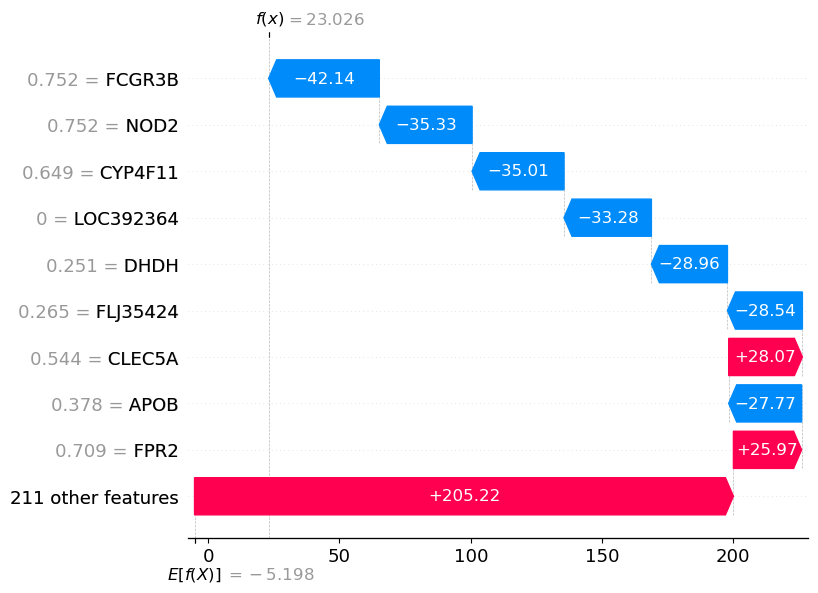

In [151]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 18

In [152]:
idx = 18

In [153]:
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[18])

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [154]:


with open("../data/models/shap/ind_18", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [155]:
shap_values = shap_values[0]

In [156]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [157]:
idx = 18
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                     
46_CD_deep_ulcer  0.438089  0.482152  0.410237  0.378247  0.438691  0.705762   

                        C6   CEACAM7    CHI3L1     ABCC2  ...      MICA  \
Patient_ID                                                ...             
46_CD_deep_ulcer  0.339106  0.559666  0.878088  0.228893  ...  0.485657   

                  LOC646430  LOC441956    ITGAV    SMCHD1      ASPN    TMEM97  \
Patient_ID                                                                      
46_CD_deep_ulcer        0.0        0.0  0.64322  0.701857  0.924527  0.782324   

                  LOC389458     PTPN7  RPS12P31  
Patient_ID                                       
46_CD_deep_ulcer    0.02108  0.606354       0.0  

[1 rows x 220 columns]

In [158]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:", np.argmax(gmm_model_get_prediction_ae(patient)[0]))

Prediction probabilities for patient: [1. 1. 1.]
Predicted class: 0


#### Control

In [159]:
import shap

In [160]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [161]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [162]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [163]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 18
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

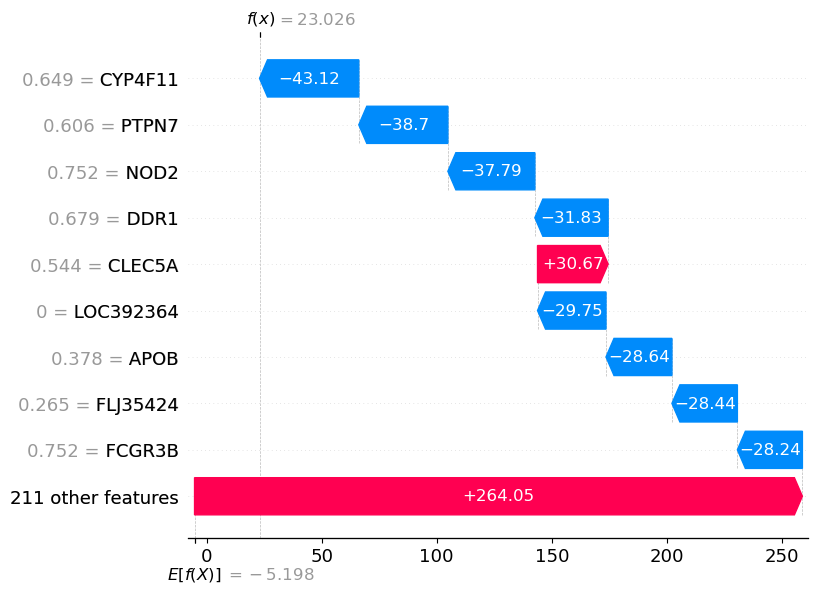

In [164]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

## Independent - 77

In [165]:
idk = 77

In [166]:
# autoencoder
explainer = objects.get_explainer(model=gmm_model_get_prediction_ae, data=x_train_scaled, link="logit", feature_dependence=False, specific_indices=[idx])
# PCA
# explainer = objects.get_explainer(model=gmm_model_get_prediction_pca, data=x_train_scaled, link="logit")

getting explainerinitialising explainer


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [167]:


with open("../data/models/shap/ind_77", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [168]:
shap_values = shap_values[0]

In [169]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (1, 220)


In [170]:
idx = 77
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...      MICA  LOC646430  \
Patient_ID                                           ...                        
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.598137        0.0   

                   LOC441956     ITGAV   SMCHD1      ASPN    TMEM97  \
Patient_ID                                                            
256_CD_deep_ulcer        0.0  0.550635  0.71262  0.543815  0.510634   

                   LOC389458     PTPN7  RPS12P31  
Patient_ID                                        
256_CD_deep_ulcer    0.02108  0.597887       0.0  

[1 rows x 220 columns]

In [171]:
print(f'Prediction probabilities for patient: {gmm_model_get_prediction_ae(patient)[0]}')
print("Predicted class:")

Prediction probabilities for patient: [1. 1. 1.]
Predicted class:


#### Control

In [172]:
import shap

In [173]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [174]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], patient, link="logit")

####  CD deep ulcer

In [175]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], patient, link="logit")

In [176]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][0], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

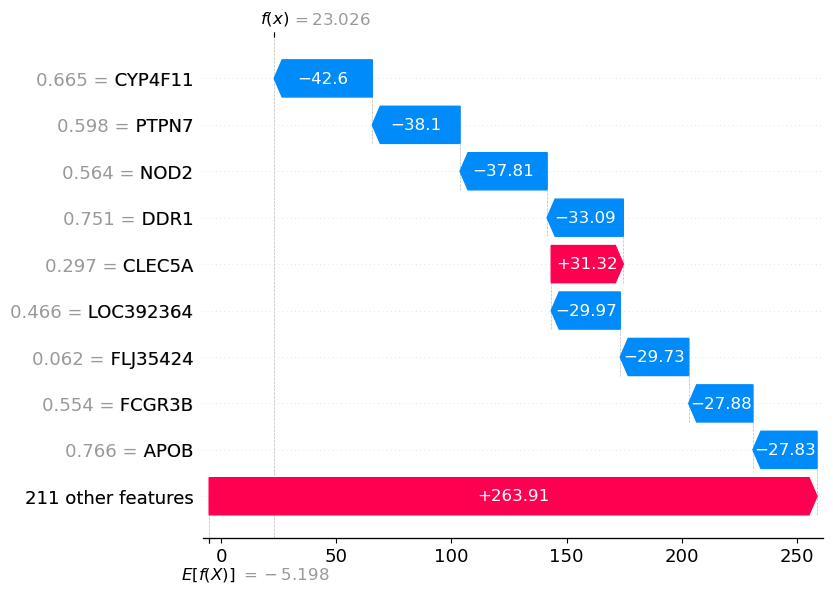

In [177]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))